<small><font color=gray>Notebook authors: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a>, Kiryll Bykov, Alexey Boldyrev ©2021 onwards</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>📈Crypto</font>](https://www.kaggle.com/competitions/11mar24hse-crypto/rules)**. [**Instructions**](https://colab.research.google.com/drive/1owkYjuRGkx050LQnM3b3yTzd0Dr2XbeV) for running Colabs.

<small>**CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes.

In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if kaggle.json is stored in Google Drive

Mounted at /content/drive


In [ ]:
%%capture
pip install -U kaggle  # upgrade kaggle package (to avoid a warning)

In [ ]:
!mkdir -p ~/.kaggle                               # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
# !cp kaggle.json ~/.kaggle/kaggle.json           # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                  # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 11mar24hse-crypto # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download                     # download competition dataset as a zip file
!unzip -o *.zip                                   # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show           # print public leaderboard

- competition is now set to: 11mar24hse-crypto
Using competition: 11mar24hse-crypto
  0% 0.00/5.94M [00:00<?, ?B/s]
100% 5.94M/5.94M [00:00<00:00, 63.9MB/s]
Archive:  11mar24hse-crypto.zip
  inflating: sampleSubmission.csv    
  inflating: tXY.csv                 
Using competition: 11mar24hse-crypto
  teamId  teamName             submissionDate       score    
--------  -------------------  -------------------  -------  
11786133  S                    2024-04-01 03:05:13  0.33482  
11764071  Kirill Kiosa         2024-04-01 07:10:59  0.18407  
11784492  F                    2024-04-01 05:48:32  0.14574  
11830152  Shutov Alexey        2024-03-25 18:29:30  0.13909  
11834008  Kuzmishin Leonid     2024-04-01 11:03:16  0.13532  
11775405  Maxim Levin          2024-03-31 16:02:35  0.13257  
11764074  Kseniia Nechaeva     2024-03-24 10:30:39  0.13254  
11767807  Roman Kholinov       2024-03-16 20:06:00  0.13233  
11766962  Gorelskii Roman      2024-03-31 07:27:54  0.13228  
11766622  X     

See [more](https://nvidia.custhelp.com/app/answers/detail/a_id/3751/~/useful-nvidia-smi-queries) about NVIDIA GPU stats. Test your code in (free) Colab. It uses Tesla T4 or Tesla K80 GPU.

In [ ]:
!nvidia-smi --query-gpu=gpu_name,memory.total,memory.free,memory.used --format=csv

name, memory.total [MiB], memory.free [MiB], memory.used [MiB]
Tesla T4, 15360 MiB, 15101 MiB, 0 MiB


In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60*5): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=5, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)

CPU times: user 2.07 s, sys: 357 ms, total: 2.42 s
Wall time: 4.56 s


Your training data are 7 descriptive features for past 500K observations. See helpful [Tutorial to the G-Research Crypto Competition](https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition).

In [ ]:
tXY = pd.read_csv('tXY.csv', index_col='id'); tXY

,Count,Open,High,Low,Close,Volume,VWAP
id,,,,,,,
0,64,0.20,0.20,0.20,0.20,447,0.20
1,72,0.20,0.20,0.20,0.20,592,0.20
...,...,...,...,...,...,...,...
499998,1636,1.15,1.16,1.15,1.15,2615,1.15
499999,3228,1.13,1.14,1.12,1.13,3354,1.13


Your task is to forecast the closing price for all future time steps (index IDs below).

In [ ]:
pY = pd.read_csv('sampleSubmission.csv', index_col='id'); pY.T

id,500000,500001,500002,500003,500004,500005,500006,500007,500008,500009,...,524421,524422,524423,524424,524425,524426,524427,524428,524429,524430
Close,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
tmr = Timer() # runtime limit (in seconds). Add all of your code after the timer

⏳ started. You have 300 sec. Good luck!


<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer Start Here...</font></strong>


**TODO. Explain your preprocessing:** i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.

* `RSI`: We added the Relative Strength Index (RSI) because it's great at spotting when the market might change direction. It felt like a no-brainer to help predict price movements better.

* `Lag Features`: We threw in lagged features of the closing price, thinking, "The past can clue us in on the future," right? It's like giving the model a peek at what happened before to guess what comes next.

* `Resampling - were was the key to the HUGE score in competition`: We've played with the variables for resampling. Finally obtaining **20,000 samples * 15 timestanps each**.

**TODO. Explain your modeling approach:** ideas you tried and why you thought they would be helpful. Takeaway: how these decisions guided you in modeling.

* `Why LSTM`: We went with an LSTM network because they're known to catch those long-term patterns in time-series data. Our hope was it'd really get the ups and downs of stock prices over time.

* `Building the Model`: We included a dropout layer to keep the model from just memorizing the training data (overfitting) and a linear layer to crunch those LSTM outputs down to our stock price predictions. It seemed like a balanced approach to tackle the complexity without going overboard.

* `MSE as the Loss Function`: We chose Mean Squared Error for the loss because, traditionally, you want to minimize how off your predictions are, right? But since the competition cared more about whether We got the direction right rather than how exact the numbers were, We kept wondering if there was a better way to align the training with that goal.

This is your baseline DNN model. Remember to [seed all your experiments](https://pytorch.org/docs/stable/notes/randomness.html#reproducibility) for reproducibility.

In [ ]:
# RSI
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

tXY['RSI'] = compute_rsi(tXY['Close'])
tXY['RSI_lag1'] = tXY['RSI'].shift(1)

# Лаговые признаки
tXY['Lag_1'] = tXY['Close'].shift(1)
tXY['Lag_2'] = tXY['Close'].shift(2)
# tXY['Lag_o1'] = tXY['High'].shift(1)
# tXY['Lag_o1'] = tXY['Low'].shift(1)
# tXY['Lag_o2'] = tXY['VWAP'].shift(2)

tXY.fillna(0, inplace=True)  # Заполнение нулями

taX.shape=(K,Nx,p)=(20000, 15, 11); taY=(K,Ny)=(20000, 24431)


<Axes: title={'center': 'Training series (before and after)- just a closing price series (out of K=20000)'}>

(20000, 15, 11)

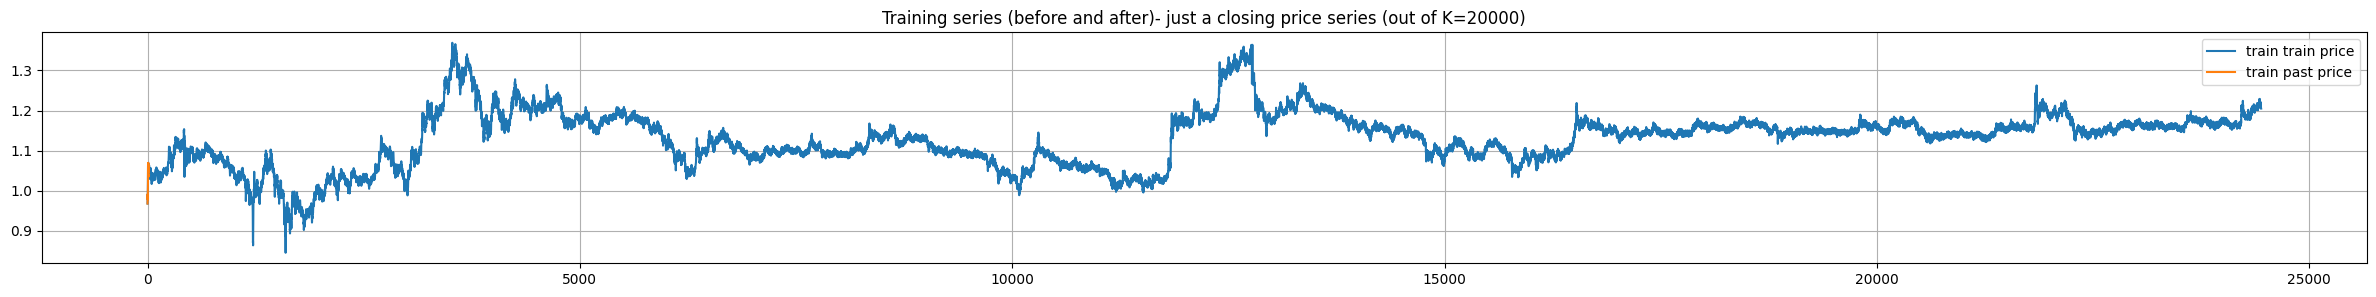

In [ ]:
K, (N, p), Nx, Ny = 20000, tXY.shape, 15, len(pY)  # samples, dataset dim, train set size, forecast set size
LtX, LtY = [], []
for i in range(N-Ny-K, N-Ny):                     # populate K samples with past X series and future Y series
  LtX.append(tXY.iloc[(i-Nx):i, :].values)        # X: historical 7Dim observations for Nx steps behind
  LtY.append(tXY.loc[i:(i+Ny-1),'Close'].values)  # Y: future closing prices for Ny steps ahead
taX, taY = np.array(LtX), np.array(LtY)           # training arrays past input X and future output Y
print(f'taX.shape=(K,Nx,p)={taX.shape}; taY=(K,Ny)={taY.shape}')  # convert to 3-tensors

df = pd.DataFrame(np.r_[taX[0,:,4], taY[0,:]], columns=['train train price'])
ax = df.plot(figsize=(30,3), title=f'Training series (before and after)- just a closing price series (out of K={K})');
pd.DataFrame(taX[0,:,4], columns=['train past price']).plot(grid=True, ax=ax);

taX.shape

Build an LSTM model with two hidden layers. It splits $K$ samples into batches with 7D series $X_{N_x\times p}$ as input and 1D series $Y_{N_y\times 1}$ as output.


In [ ]:
taX = torch.Tensor(taX)
taY = torch.Tensor(taY)

In [ ]:
ds = TensorDataset(taX, taY)

In [ ]:
dl = DataLoader(ds, batch_size=128, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch.nn as nn

class MyLSTMModel(nn.Module):
    def __init__(
        self,
        output_size,
        input_size,
        hidden_size=100,
        num_layers=2,
        bias=True,
        batch_first=True,
        dropout=0.2,
    ):
        super(MyLSTMModel, self).__init__()

        # Use LSTM instead of GRU
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            dropout=dropout, batch_first=batch_first)

        # Dropout layer remains the same
        self.dropout = nn.Dropout(dropout)

        # Linear output layer, assuming output from LSTM is not bidirectional
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        # LSTM returns output, (hn, cn)
        _, (hn, _) = self.lstm(X)

        # Select the last hidden state
        last_hidden = hn[-1]

        # Apply dropout
        last_hidden = self.dropout(last_hidden)

        # Pass through the linear layer
        output = self.linear(last_hidden)

        return output


In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

m = MyLSTMModel(Ny, p)
m.to(device)

optim = torch.optim.Adam(m.parameters(), lr=0.01)
loss = nn.MSELoss()

MyLSTMModel(
  (lstm): LSTM(11, 100, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=100, out_features=24431, bias=True)
)

In [ ]:
%%time
n_epoch = 30
m.train()

for e in range(n_epoch):
  losses = []
  print(f"Epoch: {e}")

  for i, (X, Y) in enumerate(dl):
    X = X.to(device)
    Y = Y.to(device)
    optim.zero_grad()

    pred = m(X)

    l = loss(pred, Y)
    l.backward()
    optim.step()

    losses.append(l.detach().item())

  print(f"Avg epoh loss: {sum(losses) / len(losses)}")

Epoch: 0
Avg epoh loss: 0.061651170657129044
Epoch: 1
Avg epoh loss: 0.019176090337858078
Epoch: 2
Avg epoh loss: 0.017239369766395184
Epoch: 3
Avg epoh loss: 0.0158709065253093
Epoch: 4
Avg epoh loss: 0.014995644996120671
Epoch: 5
Avg epoh loss: 0.013969092795945657
Epoch: 6
Avg epoh loss: 0.013413297036176275
Epoch: 7
Avg epoh loss: 0.012973346177986853
Epoch: 8
Avg epoh loss: 0.012551085448046779
Epoch: 9
Avg epoh loss: 0.012291392833469021
Epoch: 10
Avg epoh loss: 0.011802726573530277
Epoch: 11
Avg epoh loss: 0.011717414874939403
Epoch: 12
Avg epoh loss: 0.011483618977722848
Epoch: 13
Avg epoh loss: 0.011091220085835381
Epoch: 14
Avg epoh loss: 0.011097025689757933
Epoch: 15
Avg epoh loss: 0.010861589614847664
Epoch: 16
Avg epoh loss: 0.010695825965636096
Epoch: 17
Avg epoh loss: 0.010600191303736465
Epoch: 18
Avg epoh loss: 0.01050518412190448
Epoch: 19
Avg epoh loss: 0.010515144427016282
Epoch: 20
Avg epoh loss: 0.010436957903728363
Epoch: 21
Avg epoh loss: 0.010445822309109436
E

The plot below: the model memorized the prices from recent history (plus some local noise). Still you can use these predictions to visually (i.e. qualitatively) determine whether predictions are meaningful (i.e. have price-like shape) or just noise.

In [ ]:
m.eval();  # To disable dropout at evaluation stage

tX_recent.shape=(Nx,p)=(20000, 11)


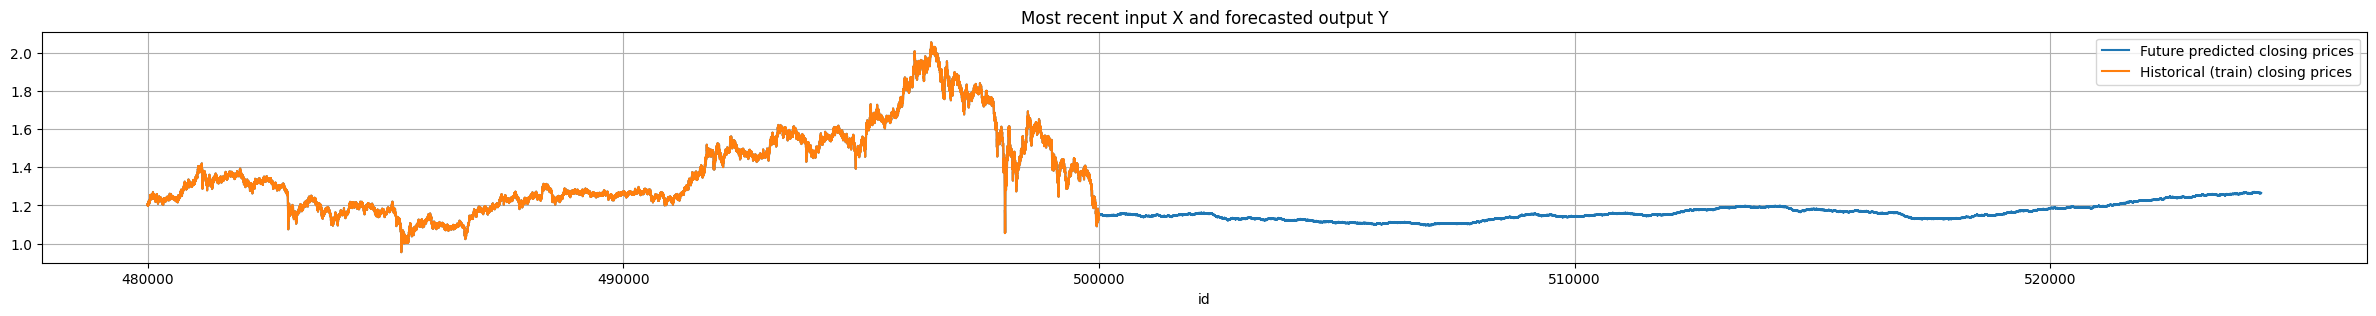

In [ ]:
tX_recent = tXY.iloc[-20000:,:]  # most recent history of the coin
print(f'tX_recent.shape=(Nx,p)={tX_recent.shape}')
with torch.no_grad():
  pY['Close'] = m(torch.Tensor(tX_recent.values[np.newaxis,...]).to(device)).cpu().numpy().flatten()
ax = pd.concat([tX_recent.Close, pY.Close]).plot(figsize=(30,3), title='Most recent input X and forecasted output Y');
tX_recent.Close.plot(ax=ax, grid=True);
ax.legend(["Future predicted closing prices", "Historical (train) closing prices"]);

1. The model generates a baseline submission CSV file, see Colab folder (🗀 on the left).
1. You can download the generated CSV file and submit it to Kaggle.

In [ ]:
ToCSV(pY, 'Crypto-baseline')

# **References:**

1. Remember to cite your sources here as well! At the least, your textbook should be cited. Google Scholar allows you to effortlessly copy/paste an APA citation format for books and publications. Also cite StackOverflow, package documentation, and other meaningful internet resources to help your peers learn from these (and to avoid plagiarism claims).

1. [Pytorch Lstm](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
2. [ISL](https://www.statlearning.com/)
3. [ESL](https://www.sas.upenn.edu/~fdiebold/NoHesitations/BookAdvanced.pdf)
4. [D2L](https://d2l.ai/)

<font size=5>⌛</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>

<hr color=red>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 67 sec


# 💡**Starter Ideas**

1. Try different RNN architectures and hyperparameters
1. Try [correlation loss/metric](https://duckduckgo.com/?q=correlation+loss+in+tensorflow&ia=web) (or equivalent)
1. Try longer/shorter history. FYI: GPU may not fit all observations, but you could lower the precision or simplify DNN
1. Try forecasting returns (differences or log differences at different lags) instead of actual values. Returns might appear "more" stationary (You'll need to compute forecasted prices from forecasted returns later)
1. Try new features: differences, fractions, powers of existing features, lagged features or lagged differences,..
1. Try a different time scale. Eg. forecasting every $k$ steps and then imputing interim values
1. Try technique in HOML pp.509-510
1. Try (programmatically) assigning higher/lower weights to history or historical events (such as extreme events)
1. Check [Kaggle G-Research Crypto Forecasting](https://www.kaggle.com/c/g-research-crypto-forecasting/code) competition for more suitable ideas.
1. Try further smoothing/averaging and forecasting values at sparser intervals
1. Try forecasting just the future trend